# Individual Analysis for the Hydrogen Laser Spectroscopy Experiment

Use this template to carry out the analysis tasks for the experiment.  You may need to consult the documentation for different Python packages.  Also recommended: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will also be using [**LMFit**](https://lmfit.github.io/lmfit-py/) for curve fitting 
and the [Uncertainties](https://pythonhosted.org/uncertainties/) package for calculating statistical uncertainty. 

In [1]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as up
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 11.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 12.0 # Use 12 point font

## Summary of tasks

### Prior to working on this notebook

1. Watch the videos on the experiment and work out exercises 1, 2 and 10.  These concern the Balmer-$\alpha$ wavelength, the term diagram of the $n=2$ to $n=3$ transitions and selection rules, and the overall layout of Doppler-free beam-crosssing method of laser spectrosopy.


2. Download the PDFs of the chart-recorder scans for the two hydrogen spectrum data runs (one for left-to-right scan, the other for right-to-left).


3. Extract from each scan the positions in paper-grid units of (1) the peaks in the Fabry-Perot (F-P) mirror output, and (2) positions of the 5 obvious peaks in the probe-beam measurement. Positions should be estimated to 1/10 of the smallest grid unit.  The F-P peak positions do not need uncertainties, but you should assign an uncertainty to the prob-beam peak positions.


4. Download the file containing the Fabry-Perot mirror separation measurements.  Note that these measurements are in inches, due to the caliper used to make the measurements.


5. Create spreadsheets with these data to be read into the notebook for further processing.  Recommended: one .xlsx file with 5 tabs (worksheets), or 5 separate .csv files, one for the mirror measurements and one for each set of peak position measurements.  Read them in with either Pandas `read_csv()` or `read_excel()`.


### Tasks for this notebook

Convert the mirror separation measurements to meters and calculate the separation with its uncertainty ("standard deviation of the mean").  Also calculate the free spectral range in Hz. 

For each scan:

<blockquote>
Plot the F-P peak index (y-axis) versus its position (x-axis).  Fit this to a 3rd-order polynomial to produce calibration coefficients.

Create a calibration function that takes paper-grid positions and returns position in FSR units (relative to an arbitrary origin).

Use the calibration function to convert probe-beam peak positions to positions in FSR units. Incorporate the uncertainty in the probe-beam peak positions to get uncertainty in FSR units.  

Convert the FSR units to frequency using the free spectral range, including uncertaities.

Finally, calculate the frequency separations requested, among them the "Lamb shift" which is the difference between the 2S<sub>1/2</sub>-3P<sub>3/2</sub> and 2P<sub>1/2</sub>-3D<sub>3/2</sub> transitions.
</blockquote>

Once the above has been completed for both scans, combine the results to obtain the the best values for the fine-structure frequency separations, and compare the measurements to the expected values.  (these can be found in the experiment instructions.)

## Read in the hydrogen spectrum data

You will probably want 5 different DataFrames: (1) Mirror separations, (2) F-P peaks for right-to-left, (3) probe-beam peaks for right-to-left, (4) F-P peaks for left-to-right, and (5) probe-beam peaks for right-to-left.

One way to do it is create a different CSV file for each DataFrame.  Another way is to put all 5 Sheets into a single Excel file.  You can read the whole file into a Pandas "OrderedDict" with the command 

    `Hdata = pd.read_excel('Hydrogen_spectrum_data.xlsx', sheet_name = None)`

Then each sheet will be in its own DataFrame that you would reference with `Hdata['sheet-name']`.

In [3]:
# Read in the data
mirror_sep = pd.read_csv('mirror_separation.CSV')
FP_peaks_LR = pd.read_csv('FP_peaks_LtoR.CSV')
FP_peaks_RL = pd.read_csv('FP_peaks_RtoL.CSV')
probe_peaks_LR = pd.read_csv('probe_peaks_LtoR.CSV')
probe_peaks_RL = pd.read_csv('probe_peaks_RtoL.CSV')

In [4]:
# Display it (This helps remember the keys to your columns, etc.)
print('Mirror separation:')
display(mirror_sep)
print('FP peaks L to R:')
display(FP_peaks_LR)
print('FP peaks R to L:')
display(FP_peaks_RL)
print('probe peaks L to R:')
display(probe_peaks_LR)
print('probe peaks R to L:')
display(probe_peaks_RL)

Mirror separation:


,separation_inch
0,3.949
1,3.947
2,3.944
3,3.940
4,3.935
5,3.948
6,3.944
7,3.931
8,3.931


FP peaks L to R:


,ind,peak_loc
0,1,2.5
1,2,17.0
2,3,29.2
3,4,41.7
4,5,53.7
5,6,64.6
6,7,75.0
7,8,86.0
8,9,95.8
9,10,105.6


FP peaks R to L:


,ind,peak_loc
0,1,10.0
1,2,20.4
2,3,30.5
3,4,41.2
4,5,51.6
5,6,62.0
6,7,72.2
7,8,83.6
8,9,94.1
9,10,105.3


probe peaks L to R:


,ind,peak_loc,width
0,1,42.3,2.0
1,2,83.4,1.8
2,3,94.9,1.7
3,4,105.7,1.6
4,5,112.6,1.6


probe peaks R to L:


,ind,peak_loc,width
0,1,32.4,1.9
1,2,70.9,1.7
2,3,82.4,1.6
3,4,94.6,1.8
4,5,102.4,1.7


##  Mirror separation & Free spectral range

Convert inches to meters.  Hint: look up `scipy.constants.inch` in SciPy.

Calculate the mean and standard deviation of the mean and save in an uncertainty object.

Calculate the free spectral range in Hz (with uncertainty).  Remember, the free spectral range is 

$$ FSR = \frac{c}{2d}$$

In [5]:
# Show a table of the mirror separation values

mirror_sep['separation_m'] = mirror_sep['separation_inch']*const.inch 
mirror_sep

,separation_inch,separation_m
0,3.949,0.100305
1,3.947,0.100254
2,3.944,0.100178
3,3.940,0.100076
4,3.935,0.099949
5,3.948,0.100279
6,3.944,0.100178
7,3.931,0.099847
8,3.931,0.099847


In [6]:
# Calculate the mean, standard deviation, and standard deviation of the mean 
# of the mirror separation values in meters.

FP_sep = np.mean(mirror_sep['separation_m'])
FP_sep_stderr = np.std(mirror_sep['separation_m'])

# Build an uncertainty object to hold the mirror separation with its uncertainty.
# Print the mirrr separation and uncertainty in cm.

uFP_sep = unc.ufloat(FP_sep, FP_sep_stderr)
print('Fabry-Perot mirror separation = {:.1uP} cm'.format(uFP_sep/const.centi))

# Print the free spectral range in MHz

uFSR = const.c/(2*uFP_sep)
print('F-P set free spectral range = {:.1uP} MHz'.format(uFSR/const.mega))

Fabry-Perot mirror separation = 10.01±0.02 cm
F-P set free spectral range = 1497±3 MHz


## Left-to-right scan analysis

### Fit the FP peaks

First, make a table of the FP peak locations.

Create an array of **indices** of the F-P peak locations. 

Fit the index array (y-axis) vs. peak locations (x-axis) to a 3rd-order polynomial to obtain calibration constants. 

In [7]:
# The indices of the Pandas DataFrame are given by the attribute 'index'
# To get an array with these indices, make a Python list, e.g., 'list(DataFrame.index)'
FP_peaks_LR



,ind,peak_loc
0,1,2.5
1,2,17.0
2,3,29.2
3,4,41.7
4,5,53.7
5,6,64.6
6,7,75.0
7,8,86.0
8,9,95.8
9,10,105.6


Then set up the fitting.

In [8]:
# Use a polynmial of degree=3
from lmfit.models import PolynomialModel

curve = PolynomialModel(degree=3)

# Recommended: Make a function to do the work, with model as a passed object.
# The return is the fit parameters structure

def poly_fit_and_plot(xdata, ydata, model=curve, plot=True, force_zero=False):
    '''
    Fit a line or curve, and plot/show the fit results.
    The function returns a parameters object with the fit parameters
    '''
    ## Fill in function
    param_guess = model.guess(ydata, x=xdata)
    if force_zero=='linear':
        param_guess['intercept'].set(value=0, vary=False)
    if force_zero=='quadratic':
        param_guess['c'].set(value=0, vary=False)

    model_fit = model.fit(ydata, param_guess, x=xdata)
    if plot==True:
        print(model_fit.fit_report())
        model_fit.plot();
        
    return model_fit.params

Execute the fitting.

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 13
    # variables        = 4
    chi-square         = 0.00610638
    reduced chi-square = 6.7849e-04
    Akaike info crit   = -91.6238259
    Bayesian info crit = -89.3640284
[[Variables]]
    c0:  0.81678040 +/- 0.02664278 (3.26%) (init = 0.8167804)
    c1:  0.06809679 +/- 0.00168935 (2.48%) (init = 0.06809679)
    c2:  2.0611e-04 +/- 2.8805e-05 (13.98%) (init = 0.0002061051)
    c3: -2.7625e-07 +/- 1.3764e-07 (49.83%) (init = -2.762452e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c3) = -0.986
    C(c1, c2) = -0.965
    C(c1, c3) =  0.911
    C(c0, c1) = -0.826
    C(c0, c2) =  0.686
    C(c0, c3) = -0.597


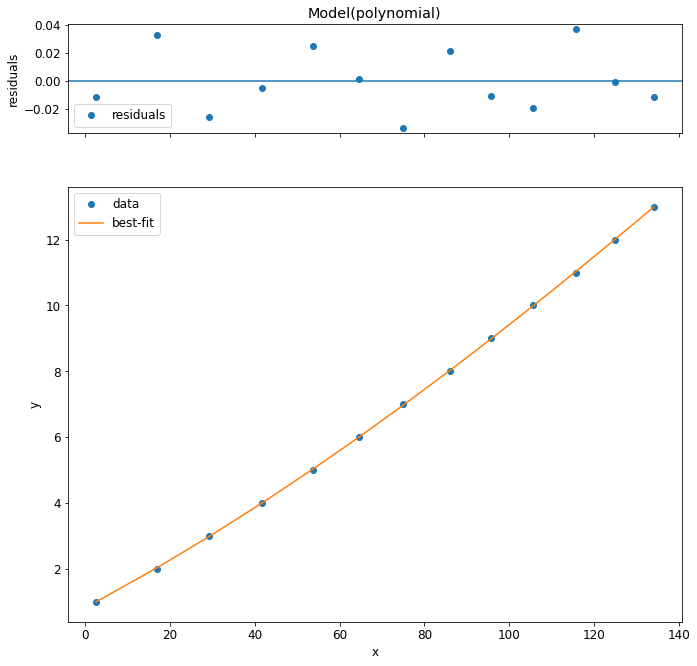

In [9]:
# Carry out the fit, show the results, and save the fit parameters

FR_LR = poly_fit_and_plot(FP_peaks_LR['peak_loc'], FP_peaks_LR['ind'])

### Make the calibration function

You can use the same method to make the calibration curve as you used in teh Zeeman effect experiment, e.g., use `eval()` with the fit coefficients.

In [10]:
# Define a calibration function.  Hint: use eval()
def cal_LR(x,model=curve,params=FR_LR):
    return model.eval(params, x=x)

# Test
# location 120 should have peak index between 11 and 12
print(cal_LR(120))

11.47895723425048


### Calculate the spectrum 

Pull the probe-beam locations and uncertainties from the spreadsheet for the left-to-right scan.  Then apply the calibration function to obtsin the peak positions and uncertainties in free-spectral-range units (FSR units), and then apply the free spectral range to obtain the spectrum in Hz (relative to an arbitrary origin).  Put these all into a single table, and diplay it.  (Recommended: Make a Pandas DataFrame.)

In [11]:
# Make uncertainty array of probe-beam paper-unit locations with uncertainty
# Use up.uarray()
probe_LR = up.uarray(probe_peaks_LR['peak_loc'], probe_peaks_LR['width']/2)


# Build Pandas DataFrame with spectrum in paper units, FSR units (applying calibration), 
# MHz (applying free spectral range), and MHz relative to the largest, lowest-frequency peak.
Left_Right_spectrum = pd.DataFrame({'Paper': probe_LR ,
                                    'FSR': cal_LR(probe_LR) ,
                                    'MHz': cal_LR(probe_LR)*uFSR/const.mega ,
                                    'Rel MHz': [(i-cal_LR(probe_LR)[0])*uFSR/const.mega for i in cal_LR(probe_LR)]
                                   })

# Show the table
print('Left-to-right scan probe-beam peak locations:')
Left_Right_spectrum


Left-to-right scan probe-beam peak locations:


,Paper,FSR,MHz,Rel MHz
0,42.3+/-1.0,4.05+/-0.08,(6.06+/-0.13)e+03,(0.0+/-1.0)e-14
1,83.4+/-0.9,7.77+/-0.09,(1.163+/-0.013)e+04,(5.58+/-0.18)e+03
2,94.9+/-0.8,8.90+/-0.08,(1.333+/-0.013)e+04,(7.27+/-0.18)e+03
3,105.7+/-0.8,9.99+/-0.08,(1.496+/-0.013)e+04,(8.90+/-0.18)e+03
4,112.6+/-0.8,10.70+/-0.08,(1.603+/-0.013)e+04,(9.97+/-0.18)e+03


### Calculate separations

Make a table that shows the following separations in MHz (with uncertainty):

* The Lamb shift: 2S<sub>1/2</sub> - 3P<sub>3/2</sub> to 2P<sub>1/2</sub> - 3D<sub>3/2</sub> frequency separation (with uncertainty) for both scans.
* The 2P<sub>3/2</sub>  - 3D<sub>5/2</sub> to 2P<sub>1/2</sub> - 3D<sub>3/2</sub>  frequency separation, i.e., highest frequency peak to lowest frequency peak (with uncertainty) for both scans.
* The 2P<sub>3/2</sub>  - 3D<sub>5/2</sub> to 2S<sub>1/2</sub> - 3P<sub>1/2</sub> frequency separation, i.e., tallest to smallest peak (with uncertaintyl) for both scans.


In [12]:
# Calculate the separations and make a table.
# Recommended: Build a DataFrame.  You can use it to add the calculated separations from the 
# other scan below and then the averages of both to compare to accepted results.

# Here is a list of the separation labels
seps_list = ['2S1/2-3P3/2 to 2P1/2-3D3/2', '2P3/2-3D5/2 to 2P1/2-3D3/2','2P3/2-3D5/2 to 2S1/2-3P1/2']

# Make a list of the separations in MHz
LR = Left_Right_spectrum['MHz']
LR_list = [LR[4]-LR[3], LR[4]-LR[0], LR[1]-LR[0]]

# Construct the DataFrame
Results = pd.DataFrame({'Separations': seps_list,
                            'L-R (MHz)':LR_list})

# Display
Results

,Separations,L-R (MHz)
0,2S1/2-3P3/2 to 2P1/2-3D3/2,(1.07+/-0.17)e+03
1,2P3/2-3D5/2 to 2P1/2-3D3/2,(9.97+/-0.18)e+03
2,2P3/2-3D5/2 to 2S1/2-3P1/2,(5.58+/-0.18)e+03


## Right-to-left scan analysis

Repeat the above process for the right-to-left scan.

### Fit the F-P peaks

<i>Points will be taken off if you redo tasks (function declarations, imports) that do not need to be redone.</i>

In [13]:
# Make a table of the F-P peaks, and index array

FP_peaks_RL

,ind,peak_loc
0,1,10.0
1,2,20.4
2,3,30.5
3,4,41.2
4,5,51.6
5,6,62.0
6,7,72.2
7,8,83.6
8,9,94.1
9,10,105.3


[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 12
    # variables        = 4
    chi-square         = 0.00320000
    reduced chi-square = 4.0000e-04
    Akaike info crit   = -90.7541465
    Bayesian info crit = -88.8145199
[[Variables]]
    c0:  0.05990980 +/- 0.03099478 (51.74%) (init = 0.0599098)
    c1:  0.09399255 +/- 0.00186399 (1.98%) (init = 0.09399255)
    c2:  7.2142e-05 +/- 3.0581e-05 (42.39%) (init = 7.214162e-05)
    c3: -6.6189e-07 +/- 1.4469e-07 (21.86%) (init = -6.618855e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c3) = -0.988
    C(c1, c2) = -0.976
    C(c1, c3) =  0.935
    C(c0, c1) = -0.921
    C(c0, c2) =  0.835
    C(c0, c3) = -0.766


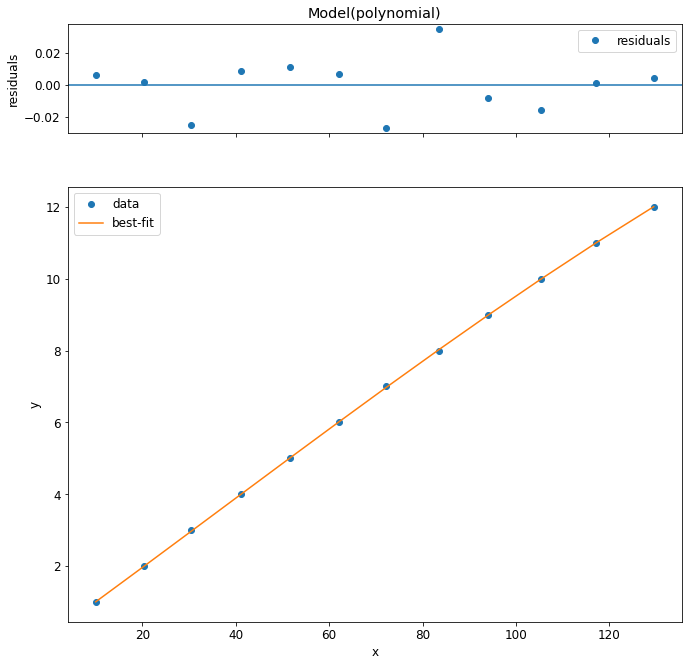

In [14]:
# Fit to a polynomial of degree=3, and show the results and save the parameters

FR_RL = poly_fit_and_plot(FP_peaks_RL['peak_loc'], FP_peaks_RL['ind'])

### Make the calibration for the R-L scan


In [15]:
# Define and test the calibration function

def cal_RL(x,model=curve,params=FR_RL):
    return model.eval(params, x=x)

# Test
# location 120 should have peak index between 11 and 12
print(cal_RL(120))

11.234117259556239


### Calculate the spectrum

Carry out the calculation and table construction for the right-to-left scan.

In [16]:
# Make uncertainty array of probe-beam paper-unit locations with uncertainty
probe_RL = up.uarray(probe_peaks_RL['peak_loc'], probe_peaks_RL['width']/2)

# Build Pandas DataFrame with spectrum in paper units, FSR units (applying calibration), 
# and MHz (applying free spectral range)
Right_Left_spectrum = pd.DataFrame({'Paper': probe_RL ,
                                    'FSR': cal_RL(probe_RL) ,
                                    'MHz': cal_RL(probe_RL)*(uFSR/const.mega) ,
                                    'Rel MHz': [(i-cal_RL(probe_RL)[0])*uFSR/const.mega for i in cal_RL(probe_RL)]
                                   })


# Show the table
print('Right-to-left scan probe-beam peak locations:')
Right_Left_spectrum

Right-to-left scan probe-beam peak locations:


,Paper,FSR,MHz,Rel MHz
0,32.4+/-1.0,3.16+/-0.09,(4.73+/-0.14)e+03,(0.0+/-2.1)e-16
1,70.9+/-0.8,6.85+/-0.08,(1.026+/-0.012)e+04,(5.53+/-0.18)e+03
2,82.4+/-0.8,7.92+/-0.07,(1.187+/-0.011)e+04,(7.14+/-0.18)e+03
3,94.6+/-0.9,9.04+/-0.08,(1.353+/-0.012)e+04,(8.80+/-0.18)e+03
4,102.4+/-0.8,9.73+/-0.07,(1.457+/-0.011)e+04,(9.84+/-0.18)e+03


### Calculate separations


Calculate the separations for the right-to-left scan.

Then include this column in the existing DataFrame so that the results can be directly compared

In [17]:
# Calculate the separations in the R to L scan, and add a column to the data frame 
# for separation measurements

# Make a list of the separations in MHz
RL = Right_Left_spectrum['MHz']
RL_list = [RL[4]-RL[3], RL[4]-RL[0], RL[1]-RL[0]]

# Include it as a column
Results['R-L (MHz)'] = RL_list

# Calculate the average from each scan, and add the column of average sepaations
Results['Average'] = (Results['R-L (MHz)']+Results['L-R (MHz)'])/2

# Add a column of the expected separations.  See the experiment instructions for values.
Results['Expected (MHz)'] = [1057.833, 9890, 5583]

# Show the completed table
Results

,Separations,L-R (MHz),R-L (MHz),Average,Expected (MHz)
0,2S1/2-3P3/2 to 2P1/2-3D3/2,(1.07+/-0.17)e+03,(1.04+/-0.16)e+03,(1.05+/-0.12)e+03,1057.833
1,2P3/2-3D5/2 to 2P1/2-3D3/2,(9.97+/-0.18)e+03,(9.84+/-0.18)e+03,(9.91+/-0.13)e+03,9890.000
2,2P3/2-3D5/2 to 2S1/2-3P1/2,(5.58+/-0.18)e+03,(5.53+/-0.18)e+03,(5.55+/-0.13)e+03,5583.000


## Present final values

The DataFrame tables have limited control over their formatting.  Assuming you have used the names provided, execute the following print commands to make a tbale with increased precision for comparison to expected results.

In [18]:
print('\n  Fine-structure line separation        |  Measured (MHz)        |  Best known value (MHz)')
print('----------------------------------------|------------------------|-------------------------')
print('{:s} (Lamb shift) |   {:.5uP}       |   {:.0f}'.format(Results.iloc[0,0],Results['Average'][0],
                                                             Results['Expected (MHz)'][0]))
print('{:s}              |   {:.5uP}       |   {:.0f}'.format(Results.iloc[1,0],Results['Average'][1],
                                                             Results['Expected (MHz)'][1]))
print('{:s}              |   {:.5uP}       |   {:.0f}'.format(Results.iloc[2,0],Results['Average'][2],
                                                             Results['Expected (MHz)'][2]))


  Fine-structure line separation        |  Measured (MHz)        |  Best known value (MHz)
----------------------------------------|------------------------|-------------------------
2S1/2-3P3/2 to 2P1/2-3D3/2 (Lamb shift) |   1052.57±120.19       |   1058
2P3/2-3D5/2 to 2P1/2-3D3/2              |   9905.69±126.40       |   9890
2P3/2-3D5/2 to 2S1/2-3P1/2              |   5552.88±128.89       |   5583
